<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/Stock_NeurIPS2018_SB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version**



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [4]:
import stable_baselines3, sb3_contrib
print("SB3 version:", stable_baselines3.__version__)
print("SB3-Contrib version:", sb3_contrib.__version__)

SB3 version: 2.6.1a1
SB3-Contrib version: 2.3.0



<a id='1.2'></a>
## 2.2. A list of Python packages
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
%matplotlib inline

import sys
sys.path.append(r"D:\FinRL-master\FinRL-master")

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint


import itertools

/usr/local/lib/python3.11/dist-packages/pandas_datareader/compat/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)
/usr/local/lib/python3.11/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


<a id='1.4'></a>
## 2.4. Create Folders

In [5]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [ ]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2023-10-01'
TRADE_START_DATE = '2023-10-01'
TRADE_END_DATE = '2025-06-01'

In [7]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2023-10-01'

In [8]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                    end_date = TRADE_END_DATE,
                    ticker_list = config_tickers.DOW_30_TICKER).fetch_data()
# yfp = YahooFinanceProcessor()
# df = yfp.download_data(['AXP', 'AMGN', 'AAPL'], '2010-01-01', '2010-02-01', '1m')
print(df)

YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (112073, 8)
Price         date       close        high         low        open     volume  \
0       2010-01-04    6.431897    6.446624    6.382909    6.414466  493729600   
1       2010-01-04   39.913239   40.016962   39.111101   39.159506    5277400   
2       2010-01-04   32.637959   32.781528   32.215229   32.550225    6894300   
3       2010-01-04   43.777546   43.941185   42.702198   43.419098    6186700   
4       2010-01-04   39.403481   39.834193   38.703572   38.797792    7325600   
...            ...         ...         ...         ...         ...        ...   
112068  2025-02-28  469.605164  470.989374  459.243337  461.734915    6146300   
112069  2025-02-28  362.108612  363.396482  353.123534  354.121876   15857300   
112070  2025-02-28   41.743721   42.382952   41.269142   42.063338   25197500   
112071  2025-02-28   10.680000   11.490000   10.480000   10.630000   52407400   
112072  2025-02-28   98.102760   98.351474   96.670165   97.286979   2545130

In [9]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [10]:
df.shape

(112073, 8)

In [11]:
df.sort_values(['date','tic'],ignore_index=True).head()

Price,date,close,high,low,open,volume,tic,day
0,2010-01-04,6.431897,6.446624,6.382909,6.414466,493729600,AAPL,0
1,2010-01-04,39.913239,40.016962,39.111101,39.159506,5277400,AMGN,0
2,2010-01-04,32.637959,32.781528,32.215229,32.550225,6894300,AXP,0
3,2010-01-04,43.777546,43.941185,42.702198,43.419098,6186700,BA,0
4,2010-01-04,39.403481,39.834193,38.703572,38.797792,7325600,CAT,0


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [12]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3812, 8)
Successfully added vix
Successfully added turbulence index


In [13]:
print(processed)

              date       close        high         low        open     volume  \
0       2010-01-04    6.431897    6.446624    6.382909    6.414466  493729600   
1       2010-01-04   39.913239   40.016962   39.111101   39.159506    5277400   
2       2010-01-04   32.637959   32.781528   32.215229   32.550225    6894300   
3       2010-01-04   43.777546   43.941185   42.702198   43.419098    6186700   
4       2010-01-04   39.403481   39.834193   38.703572   38.797792    7325600   
...            ...         ...         ...         ...         ...        ...   
110543  2025-02-27  463.277313  470.040193  459.777216  460.914274    4216800   
110544  2025-02-27  355.150177  359.712607  351.096911  351.316547    7298100   
110545  2025-02-27   41.908375   42.053652   41.540332   41.724355   19212300   
110546  2025-02-27   11.230000   11.850000   11.190000   11.700000   18971100   
110547  2025-02-27   96.292122   97.535692   95.317160   95.406701   16431500   

         tic  day       mac

In [14]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [15]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,AAPL,6.431897,6.446624,6.382909,6.414466,493729600.0,0.0,0.0,6.453181,6.421732,100.0,66.666667,100.0,6.431897,6.431897,20.040001,0.0
1,2010-01-04,AMGN,39.913239,40.016962,39.111101,39.159506,5277400.0,0.0,0.0,6.453181,6.421732,100.0,66.666667,100.0,39.913239,39.913239,20.040001,0.0
2,2010-01-04,AXP,32.637959,32.781528,32.215229,32.550225,6894300.0,0.0,0.0,6.453181,6.421732,100.0,66.666667,100.0,32.637959,32.637959,20.040001,0.0
3,2010-01-04,BA,43.777546,43.941185,42.702198,43.419098,6186700.0,0.0,0.0,6.453181,6.421732,100.0,66.666667,100.0,43.777546,43.777546,20.040001,0.0
4,2010-01-04,CAT,39.403481,39.834193,38.703572,38.797792,7325600.0,0.0,0.0,6.453181,6.421732,100.0,66.666667,100.0,39.403481,39.403481,20.040001,0.0
5,2010-01-04,CRM,18.542521,18.718478,18.386389,18.490477,7906000.0,0.0,0.0,6.453181,6.421732,100.0,66.666667,100.0,18.542521,18.542521,20.040001,0.0
6,2010-01-04,CSCO,16.158167,16.256333,15.713146,15.778591,59853700.0,0.0,0.0,6.453181,6.421732,100.0,66.666667,100.0,16.158167,16.158167,20.040001,0.0
7,2010-01-04,CVX,42.603539,42.678981,42.118553,42.140105,10173800.0,0.0,0.0,6.453181,6.421732,100.0,66.666667,100.0,42.603539,42.603539,20.040001,0.0
8,2010-01-04,DIS,27.475878,28.058466,27.304529,27.844279,13700400.0,0.0,0.0,6.453181,6.421732,100.0,66.666667,100.0,27.475878,27.475878,20.040001,0.0
9,2010-01-04,GS,131.992050,132.884299,129.269537,129.681351,9135000.0,0.0,0.0,6.453181,6.421732,100.0,66.666667,100.0,131.992050,131.992050,20.040001,0.0


In [16]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [17]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
train_length = len(train)
trade_length = len(trade)
print(train_length)
print(trade_length)

100311
10237


In [18]:
train.tail()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
3458,2023-09-29,UNH,489.152222,494.672516,488.773839,494.643412,3006200.0,4.0,4.758837,499.945979,450.959713,55.148635,128.373349,19.202162,475.052342,477.039840,17.52,57.50811
3458,2023-09-29,V,227.020615,230.001369,226.665293,229.813836,6045200.0,4.0,-3.066166,251.200600,224.032597,41.887451,-154.263045,36.909261,238.148430,237.149249,17.52,57.50811
3458,2023-09-29,VZ,28.312365,28.609378,28.277421,28.495813,19787600.0,4.0,-0.276669,30.421857,28.184127,41.243793,-137.570497,33.867127,29.353076,29.363413,17.52,57.50811
3458,2023-09-29,WBA,20.083012,20.254585,18.854913,18.963276,25663400.0,4.0,-1.050146,20.962601,18.592988,36.119152,-53.011683,26.754781,20.958936,23.656805,17.52,57.50811
3458,2023-09-29,WMT,52.213688,53.258418,51.972091,53.225770,18842400.0,4.0,0.139828,54.153630,52.232612,50.578516,-24.940899,17.468334,52.741928,52.075983,17.52,57.50811


In [19]:
trade.head()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2023-10-02,AAPL,172.259918,172.805204,169.464095,169.751617,52164500.0,0.0,-2.561661,183.575475,165.836040,45.243176,-87.977093,26.128886,176.566330,181.009780,17.610001,34.480822
0,2023-10-02,AMGN,252.198318,254.262794,250.370595,253.524127,1912300.0,0.0,3.867162,261.151690,237.536325,59.425501,72.229212,31.543103,247.539638,237.412813,17.610001,34.480822
0,2023-10-02,AXP,145.907852,146.317814,144.531558,144.873186,2657600.0,0.0,-3.052556,160.817407,143.761834,37.445549,-174.733161,36.526928,153.348370,158.819426,17.610001,34.480822
0,2023-10-02,BA,187.830002,192.440002,186.929993,191.470001,5244700.0,0.0,-8.257769,223.250012,185.200986,32.814602,-138.625438,66.417390,211.389666,218.712000,17.610001,34.480822
0,2023-10-02,CAT,262.851044,267.774902,261.419340,263.741028,1778200.0,0.0,-0.878850,277.101095,259.928757,51.346803,-69.197028,1.038448,268.083490,264.021853,17.610001,34.480822


In [20]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [21]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [22]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training



In [23]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [24]:
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent import MlpLstmPolicy
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback, CallbackList
from stable_baselines3.common.vec_env import DummyVecEnv

# -------------------
# 1) Policy kwargs
# -------------------
policy_kwargs = dict(
    lstm_hidden_size=256,
    n_lstm_layers=1,
    shared_lstm=True,           # Use the same LSTM for actor & critic
    enable_critic_lstm=False,   # Must be False when shared_lstm=True
    net_arch=dict(pi=[128, 128], vf=[128, 128]),
    ortho_init=False
)

# -------------------
# 2) (Optional) Eval env
#    If you don’t have a separate validation set, use env_train instead.
# -------------------
# eval_env = env_train
# OR, if you have a validation df called `val`:
# eval_env = DummyVecEnv([lambda: StockTradingEnv(df=val, **env_kwargs)])

eval_env = env_train  # <- change to a real validation env if you have one

# -------------------
# 3) Define callbacks
# -------------------
eval_callback = EvalCallback(
    eval_env=eval_env,
    best_model_save_path="./recurrent_ppo_checkpoints/",
    log_path="./recurrent_ppo_eval_logs/",
    eval_freq=10_000,              # evaluate every 10k steps
    deterministic=True,
    render=False
)

checkpoint_callback = CheckpointCallback(
    save_freq=50_000,              # save every 50k steps
    save_path="./recurrent_ppo_checkpoints/",
    name_prefix="recurrent_ppo"
)

callback = CallbackList([eval_callback, checkpoint_callback])

# -------------------
# 4) Instantiate the model (changed hypers)
# -------------------
model_ppo = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=env_train,
    learning_rate=1e-4,            # ↓ was 2.5e-4
    n_steps=4096,                  # ↑ was 2048
    batch_size=512,                # ↑ was 256 (must divide n_steps)
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    vf_coef=0.5,
    max_grad_norm=0.5,
    target_kl=None,                # you can set e.g. 0.02 if you want early stopping on large KL
    tensorboard_log="./tensorboard_recurrent_ppo/",
    policy_kwargs=policy_kwargs,
    verbose=1
)



Using cpu device


### Agent Training: 5 algorithms (PPO)


In [ ]:
trained_ppo = model_ppo.learn(total_timesteps=200_000)

# -------------------
# 6) Save
# -------------------
trained_ppo.save(f"./recurrent_ppo_stock_model_{total_timesteps//1000}k")
print("Training finished and model saved.")

Logging to ./tensorboard_recurrent_ppo/RecurrentPPO_1


Output()

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

-----------------------------
| time/              |      |
|    fps             | 59   |
|    iterations      | 1    |
|    time_elapsed    | 69   |
|    total_timesteps | 4096 |
-----------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

-------------------------------------------
| time/                   |               |
|    fps                  | 43            |
|    iterations           | 2             |
|    time_elapsed         | 189           |
|    total_timesteps      | 8192          |
| train/                  |               |
|    approx_kl            | 0.018564092   |
|    clip_fraction        | 0.23          |
|    clip_range           | 0.2           |
|    entropy_loss         | -41.1         |
|    explained_variance   | -0.0014150143 |
|    learning_rate        | 0.0001        |
|    loss                 | 2.4           |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.039        |
|    std                  | 1             |
|    value_loss           | 41.2          |
-------------------------------------------


/usr/local/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation 
environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and 
rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Eval num_timesteps=10000, episode_reward=271.27 +/- 0.00

Episode length: 3459.00 +/- 0.00

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

New best mean reward!

------------------------------
| time/              |       |
|    fps             | 21    |
|    iterations      | 3     |
|    time_elapsed    | 584   |
|    total_timesteps | 12288 |
------------------------------


day: 3458, episode: 10

begin_total_asset: 1000000.00

end_total_asset: 2573366.18

total_reward: 1573366.18

total_cost: 443152.56

total_trades: 92174

Sharpe: 0.489

=================================

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

------------------------------------------
| time/                   |              |
|    fps                  | 24           |
|    iterations           | 4            |
|    time_elapsed         | 667          |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.020081326  |
|    clip_fraction        | 0.229        |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.2        |
|    explained_variance   | -0.013566494 |
|    learning_rate        | 0.0001       |
|    loss                 | 3.62         |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.029       |
|    std                  | 1            |
|    value_loss           | 57.5         |
------------------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation 
environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and 
rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Eval num_timesteps=20000, episode_reward=279.62 +/- 0.00

Episode length: 3459.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 3.46e+03     |
|    mean_reward          | 280          |
| time/                   |              |
|    total_timesteps      | 20000        |
| train/                  |              |
|    approx_kl            | 0.023278512  |
|    clip_fraction        | 0.248        |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.2        |
|    explained_variance   | -0.004914403 |
|    learning_rate        | 0.0001       |
|    loss                 | 61.9         |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.0236      |
|    std                  | 1            |
|    value_loss           | 47.2         |
------------------------------------------


New best mean reward!

------------------------------
| time/              |       |
|    fps             | 19    |
|    iterations      | 5     |
|    time_elapsed    | 1064  |
|    total_timesteps | 20480 |
------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

-------------------------------------------
| time/                   |               |
|    fps                  | 21            |
|    iterations           | 6             |
|    time_elapsed         | 1166          |
|    total_timesteps      | 24576         |
| train/                  |               |
|    approx_kl            | 0.017726293   |
|    clip_fraction        | 0.206         |
|    clip_range           | 0.2           |
|    entropy_loss         | -41.1         |
|    explained_variance   | -0.0048891306 |
|    learning_rate        | 0.0001        |
|    loss                 | 2.36          |
|    n_updates            | 50            |
|    policy_gradient_loss | -0.0232       |
|    std                  | 1             |
|    value_loss           | 50.3          |
-------------------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

------------------------------------------
| time/                   |              |
|    fps                  | 22           |
|    iterations           | 7            |
|    time_elapsed         | 1271         |
|    total_timesteps      | 28672        |
| train/                  |              |
|    approx_kl            | 0.022121709  |
|    clip_fraction        | 0.228        |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.1        |
|    explained_variance   | 0.0017607212 |
|    learning_rate        | 0.0001       |
|    loss                 | 3.87         |
|    n_updates            | 60           |
|    policy_gradient_loss | -0.0296      |
|    std                  | 1            |
|    value_loss           | 34.7         |
------------------------------------------


/usr/local/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation 
environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and 
rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Eval num_timesteps=30000, episode_reward=284.22 +/- 0.00

Episode length: 3459.00 +/- 0.00

-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 3.46e+03      |
|    mean_reward          | 284           |
| time/                   |               |
|    total_timesteps      | 30000         |
| train/                  |               |
|    approx_kl            | 0.022663886   |
|    clip_fraction        | 0.231         |
|    clip_range           | 0.2           |
|    entropy_loss         | -41.2         |
|    explained_variance   | -0.0011490583 |
|    learning_rate        | 0.0001        |
|    loss                 | 9.69          |
|    n_updates            | 70            |
|    policy_gradient_loss | -0.0274       |
|    std                  | 1             |
|    value_loss           | 34.4          |
-------------------------------------------


New best mean reward!

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

------------------------------
| time/              |       |
|    fps             | 19    |
|    iterations      | 8     |
|    time_elapsed    | 1664  |
|    total_timesteps | 32768 |
------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

------------------------------------------
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 9            |
|    time_elapsed         | 1747         |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 0.022414785  |
|    clip_fraction        | 0.217        |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.2        |
|    explained_variance   | -0.007137656 |
|    learning_rate        | 0.0001       |
|    loss                 | 14.9         |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.0243      |
|    std                  | 1            |
|    value_loss           | 46           |
------------------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation 
environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and 
rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

day: 3458, episode: 30

begin_total_asset: 1000000.00

end_total_asset: 3611831.34

total_reward: 2611831.34

total_cost: 3778.51

total_trades: 49967

Sharpe: 0.622

=================================

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Eval num_timesteps=40000, episode_reward=261.78 +/- 0.00

Episode length: 3459.00 +/- 0.00

-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 3.46e+03      |
|    mean_reward          | 262           |
| time/                   |               |
|    total_timesteps      | 40000         |
| train/                  |               |
|    approx_kl            | 0.018390417   |
|    clip_fraction        | 0.204         |
|    clip_range           | 0.2           |
|    entropy_loss         | -41.2         |
|    explained_variance   | -0.0034220219 |
|    learning_rate        | 0.0001        |
|    loss                 | 3.28          |
|    n_updates            | 90            |
|    policy_gradient_loss | -0.0252       |
|    std                  | 1             |
|    value_loss           | 50.3          |
-------------------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

------------------------------
| time/              |       |
|    fps             | 19    |
|    iterations      | 10    |
|    time_elapsed    | 2145  |
|    total_timesteps | 40960 |
------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

-----------------------------------------
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 11          |
|    time_elapsed         | 2246        |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.019240048 |
|    clip_fraction        | 0.207       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.003051877 |
|    learning_rate        | 0.0001      |
|    loss                 | 2.21        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0256     |
|    std                  | 1           |
|    value_loss           | 26.8        |
-----------------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

------------------------------------------
| time/                   |              |
|    fps                  | 20           |
|    iterations           | 12           |
|    time_elapsed         | 2348         |
|    total_timesteps      | 49152        |
| train/                  |              |
|    approx_kl            | 0.02000969   |
|    clip_fraction        | 0.198        |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.2        |
|    explained_variance   | 0.0045419335 |
|    learning_rate        | 0.0001       |
|    loss                 | 19.7         |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.0255      |
|    std                  | 1            |
|    value_loss           | 32.5         |
------------------------------------------


/usr/local/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation 
environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and 
rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

day: 3458, episode: 40

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

total_reward: 4051733.76

total_cost: 4189.93

total_trades: 48469

Sharpe: 0.766

=================================

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Eval num_timesteps=50000, episode_reward=404.94 +/- 0.00

Episode length: 3459.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 3.46e+03     |
|    mean_reward          | 405          |
| time/                   |              |
|    total_timesteps      | 50000        |
| train/                  |              |
|    approx_kl            | 0.027602784  |
|    clip_fraction        | 0.275        |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.1        |
|    explained_variance   | 0.0050334334 |
|    learning_rate        | 0.0001       |
|    loss                 | 3.82         |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.0245      |
|    std                  | 1            |
|    value_loss           | 43.4         |
------------------------------------------


New best mean reward!

------------------------------
| time/              |       |
|    fps             | 19    |
|    iterations      | 13    |
|    time_elapsed    | 2739  |
|    total_timesteps | 53248 |
------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

------------------------------------------
| time/                   |              |
|    fps                  | 20           |
|    iterations           | 14           |
|    time_elapsed         | 2819         |
|    total_timesteps      | 57344        |
| train/                  |              |
|    approx_kl            | 0.025520116  |
|    clip_fraction        | 0.248        |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.1        |
|    explained_variance   | -0.007183671 |
|    learning_rate        | 0.0001       |
|    loss                 | 61.3         |
|    n_updates            | 130          |
|    policy_gradient_loss | -0.0226      |
|    std                  | 0.999        |
|    value_loss           | 75.2         |
------------------------------------------


/usr/local/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation 
environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and 
rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Eval num_timesteps=60000, episode_reward=279.42 +/- 0.00

Episode length: 3459.00 +/- 0.00

-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 3.46e+03      |
|    mean_reward          | 279           |
| time/                   |               |
|    total_timesteps      | 60000         |
| train/                  |               |
|    approx_kl            | 0.021917332   |
|    clip_fraction        | 0.242         |
|    clip_range           | 0.2           |
|    entropy_loss         | -41.1         |
|    explained_variance   | -0.0006275177 |
|    learning_rate        | 0.0001        |
|    loss                 | 5.84          |
|    n_updates            | 140           |
|    policy_gradient_loss | -0.0201       |
|    std                  | 0.999         |
|    value_loss           | 59.5          |
-------------------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

------------------------------
| time/              |       |
|    fps             | 19    |
|    iterations      | 15    |
|    time_elapsed    | 3217  |
|    total_timesteps | 61440 |
------------------------------


day: 3458, episode: 50

begin_total_asset: 1000000.00

end_total_asset: 3246476.68

total_reward: 2246476.68

total_cost: 331398.44

total_trades: 86432

Sharpe: 0.576

=================================

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

------------------------------------------
| time/                   |              |
|    fps                  | 19           |
|    iterations           | 16           |
|    time_elapsed         | 3296         |
|    total_timesteps      | 65536        |
| train/                  |              |
|    approx_kl            | 0.022863384  |
|    clip_fraction        | 0.256        |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.1        |
|    explained_variance   | 0.0006005168 |
|    learning_rate        | 0.0001       |
|    loss                 | 2.59         |
|    n_updates            | 150          |
|    policy_gradient_loss | -0.0244      |
|    std                  | 0.999        |
|    value_loss           | 32.7         |
------------------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

-----------------------------------------
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 17          |
|    time_elapsed         | 3394        |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.01601892  |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.1       |
|    explained_variance   | 0.015733182 |
|    learning_rate        | 0.0001      |
|    loss                 | 4.14        |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0204     |
|    std                  | 0.999       |
|    value_loss           | 55.8        |
-----------------------------------------


/usr/local/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation 
environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and 
rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Eval num_timesteps=70000, episode_reward=317.39 +/- 0.00

Episode length: 3459.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 3.46e+03     |
|    mean_reward          | 317          |
| time/                   |              |
|    total_timesteps      | 70000        |
| train/                  |              |
|    approx_kl            | 0.024317201  |
|    clip_fraction        | 0.259        |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.1        |
|    explained_variance   | 0.0013748407 |
|    learning_rate        | 0.0001       |
|    loss                 | 12.3         |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.0231      |
|    std                  | 0.999        |
|    value_loss           | 94           |
------------------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

------------------------------
| time/              |       |
|    fps             | 19    |
|    iterations      | 18    |
|    time_elapsed    | 3768  |
|    total_timesteps | 73728 |
------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

-----------------------------------------
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 19          |
|    time_elapsed         | 3865        |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.022015184 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.1       |
|    explained_variance   | 0.007919371 |
|    learning_rate        | 0.0001      |
|    loss                 | 8.76        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.0207     |
|    std                  | 0.999       |
|    value_loss           | 66.8        |
-----------------------------------------


/usr/local/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation 
environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and 
rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Eval num_timesteps=80000, episode_reward=250.99 +/- 0.00

Episode length: 3459.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 3.46e+03   |
|    mean_reward          | 251        |
| time/                   |            |
|    total_timesteps      | 80000      |
| train/                  |            |
|    approx_kl            | 0.02545924 |
|    clip_fraction        | 0.254      |
|    clip_range           | 0.2        |
|    entropy_loss         | -41.1      |
|    explained_variance   | 0.01206547 |
|    learning_rate        | 0.0001     |
|    loss                 | 86.6       |
|    n_updates            | 190        |
|    policy_gradient_loss | -0.0246    |
|    std                  | 0.999      |
|    value_loss           | 64.9       |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 19    |
|    iterations      | 20    |
|    time_elapsed    | 4249  |
|    total_timesteps | 81920 |
------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

-----------------------------------------
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 21          |
|    time_elapsed         | 4331        |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.036493458 |
|    clip_fraction        | 0.335       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.1       |
|    explained_variance   | 0.041579783 |
|    learning_rate        | 0.0001      |
|    loss                 | 4.2         |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0181     |
|    std                  | 0.999       |
|    value_loss           | 28.3        |
-----------------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation 
environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and 
rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

day: 3458, episode: 70

begin_total_asset: 1000000.00

end_total_asset: 4541682.95

total_reward: 3541682.95

total_cost: 6177.46

total_trades: 50736

Sharpe: 0.665

=================================

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Eval num_timesteps=90000, episode_reward=352.28 +/- 0.00

Episode length: 3459.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 3.46e+03    |
|    mean_reward          | 352         |
| time/                   |             |
|    total_timesteps      | 90000       |
| train/                  |             |
|    approx_kl            | 0.028085086 |
|    clip_fraction        | 0.297       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.1       |
|    explained_variance   | 0.030654311 |
|    learning_rate        | 0.0001      |
|    loss                 | 27.2        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0211     |
|    std                  | 0.999       |
|    value_loss           | 66.3        |
-----------------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

------------------------------
| time/              |       |
|    fps             | 19    |
|    iterations      | 22    |
|    time_elapsed    | 4708  |
|    total_timesteps | 90112 |
------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

------------------------------------------
| time/                   |              |
|    fps                  | 19           |
|    iterations           | 23           |
|    time_elapsed         | 4808         |
|    total_timesteps      | 94208        |
| train/                  |              |
|    approx_kl            | 0.027584437  |
|    clip_fraction        | 0.267        |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.1        |
|    explained_variance   | 0.0037633777 |
|    learning_rate        | 0.0001       |
|    loss                 | 12.4         |
|    n_updates            | 220          |
|    policy_gradient_loss | -0.0269      |
|    std                  | 1            |
|    value_loss           | 71.4         |
------------------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

----------------------------------------
| time/                   |            |
|    fps                  | 20         |
|    iterations           | 24         |
|    time_elapsed         | 4908       |
|    total_timesteps      | 98304      |
| train/                  |            |
|    approx_kl            | 0.0298157  |
|    clip_fraction        | 0.299      |
|    clip_range           | 0.2        |
|    entropy_loss         | -41.1      |
|    explained_variance   | 0.06727916 |
|    learning_rate        | 0.0001     |
|    loss                 | 9.27       |
|    n_updates            | 230        |
|    policy_gradient_loss | -0.0188    |
|    std                  | 1          |
|    value_loss           | 35.6       |
----------------------------------------


/usr/local/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation 
environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and 
rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

day: 3458, episode: 80

begin_total_asset: 1000000.00

end_total_asset: 4498829.91

total_reward: 3498829.91

total_cost: 2186.56

total_trades: 42191

Sharpe: 0.637

=================================

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Eval num_timesteps=100000, episode_reward=351.47 +/- 0.00

Episode length: 3459.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 3.46e+03    |
|    mean_reward          | 351         |
| time/                   |             |
|    total_timesteps      | 100000      |
| train/                  |             |
|    approx_kl            | 0.035313115 |
|    clip_fraction        | 0.329       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.1       |
|    explained_variance   | 0.017461777 |
|    learning_rate        | 0.0001      |
|    loss                 | 4           |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.0262     |
|    std                  | 1           |
|    value_loss           | 59.1        |
-----------------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

-----------------------------------------
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 26          |
|    time_elapsed         | 5360        |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.023392884 |
|    clip_fraction        | 0.255       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.053213418 |
|    learning_rate        | 0.0001      |
|    loss                 | 5.24        |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.0226     |
|    std                  | 1           |
|    value_loss           | 57.1        |
-----------------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation 
environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and 
rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Eval num_timesteps=110000, episode_reward=313.70 +/- 0.00

Episode length: 3459.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 3.46e+03   |
|    mean_reward          | 314        |
| time/                   |            |
|    total_timesteps      | 110000     |
| train/                  |            |
|    approx_kl            | 0.02566181 |
|    clip_fraction        | 0.254      |
|    clip_range           | 0.2        |
|    entropy_loss         | -41.2      |
|    explained_variance   | 0.12634504 |
|    learning_rate        | 0.0001     |
|    loss                 | 42.5       |
|    n_updates            | 260        |
|    policy_gradient_loss | -0.023     |
|    std                  | 1          |
|    value_loss           | 78.5       |
----------------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

-------------------------------
| time/              |        |
|    fps             | 19     |
|    iterations      | 27     |
|    time_elapsed    | 5741   |
|    total_timesteps | 110592 |
-------------------------------


day: 3458, episode: 90

begin_total_asset: 1000000.00

end_total_asset: 2238102.28

total_reward: 1238102.28

total_cost: 359944.58

total_trades: 85320

Sharpe: 0.408

=================================

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

-----------------------------------------
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 28          |
|    time_elapsed         | 5843        |
|    total_timesteps      | 114688      |
| train/                  |             |
|    approx_kl            | 0.030780148 |
|    clip_fraction        | 0.286       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.027448237 |
|    learning_rate        | 0.0001      |
|    loss                 | 26.8        |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.0266     |
|    std                  | 1           |
|    value_loss           | 42.3        |
-----------------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

----------------------------------------
| time/                   |            |
|    fps                  | 19         |
|    iterations           | 29         |
|    time_elapsed         | 5946       |
|    total_timesteps      | 118784     |
| train/                  |            |
|    approx_kl            | 0.02430748 |
|    clip_fraction        | 0.253      |
|    clip_range           | 0.2        |
|    entropy_loss         | -41.2      |
|    explained_variance   | 0.20818073 |
|    learning_rate        | 0.0001     |
|    loss                 | 10.4       |
|    n_updates            | 280        |
|    policy_gradient_loss | -0.0212    |
|    std                  | 1          |
|    value_loss           | 51.2       |
----------------------------------------


/usr/local/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation 
environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and 
rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Eval num_timesteps=120000, episode_reward=337.46 +/- 0.00

Episode length: 3459.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 3.46e+03    |
|    mean_reward          | 337         |
| time/                   |             |
|    total_timesteps      | 120000      |
| train/                  |             |
|    approx_kl            | 0.034530446 |
|    clip_fraction        | 0.324       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.12046069  |
|    learning_rate        | 0.0001      |
|    loss                 | 5.53        |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.0217     |
|    std                  | 1           |
|    value_loss           | 51.5        |
-----------------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

-------------------------------
| time/              |        |
|    fps             | 19     |
|    iterations      | 30     |
|    time_elapsed    | 6328   |
|    total_timesteps | 122880 |
-------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

-----------------------------------------
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 31          |
|    time_elapsed         | 6409        |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.033353165 |
|    clip_fraction        | 0.307       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.010990083 |
|    learning_rate        | 0.0001      |
|    loss                 | 4.87        |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.0195     |
|    std                  | 1           |
|    value_loss           | 55.3        |
-----------------------------------------


/usr/local/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation 
environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and 
rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Eval num_timesteps=130000, episode_reward=638.85 +/- 0.00

Episode length: 3459.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 3.46e+03    |
|    mean_reward          | 639         |
| time/                   |             |
|    total_timesteps      | 130000      |
| train/                  |             |
|    approx_kl            | 0.03362567  |
|    clip_fraction        | 0.314       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.019945681 |
|    learning_rate        | 0.0001      |
|    loss                 | 37.5        |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.0145     |
|    std                  | 1           |
|    value_loss           | 71.7        |
-----------------------------------------


New best mean reward!

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

-------------------------------
| time/              |        |
|    fps             | 19     |
|    iterations      | 32     |
|    time_elapsed    | 6810   |
|    total_timesteps | 131072 |
-------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

-----------------------------------------
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 33          |
|    time_elapsed         | 6895        |
|    total_timesteps      | 135168      |
| train/                  |             |
|    approx_kl            | 0.02798232  |
|    clip_fraction        | 0.27        |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.019918144 |
|    learning_rate        | 0.0001      |
|    loss                 | 5.23        |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.0272     |
|    std                  | 1           |
|    value_loss           | 62.8        |
-----------------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

------------------------------------------
| time/                   |              |
|    fps                  | 19           |
|    iterations           | 34           |
|    time_elapsed         | 6996         |
|    total_timesteps      | 139264       |
| train/                  |              |
|    approx_kl            | 0.027942918  |
|    clip_fraction        | 0.289        |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.2        |
|    explained_variance   | 0.0015868545 |
|    learning_rate        | 0.0001       |
|    loss                 | 21.7         |
|    n_updates            | 330          |
|    policy_gradient_loss | -0.0233      |
|    std                  | 1            |
|    value_loss           | 66           |
------------------------------------------


/usr/local/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation 
environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and 
rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

day: 3458, episode: 110

begin_total_asset: 1000000.00

end_total_asset: 5964689.78

total_reward: 4964689.78

total_cost: 4051.10

total_trades: 53060

Sharpe: 0.765

=================================

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Eval num_timesteps=140000, episode_reward=493.23 +/- 0.00

Episode length: 3459.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 3.46e+03     |
|    mean_reward          | 493          |
| time/                   |              |
|    total_timesteps      | 140000       |
| train/                  |              |
|    approx_kl            | 0.02818168   |
|    clip_fraction        | 0.292        |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.2        |
|    explained_variance   | 0.0070670247 |
|    learning_rate        | 0.0001       |
|    loss                 | 153          |
|    n_updates            | 340          |
|    policy_gradient_loss | -0.0179      |
|    std                  | 1            |
|    value_loss           | 105          |
------------------------------------------
-------------------------------
| time/              |        |
|    fps             | 19     |
|    iterations      | 35     |
|    time_elapsed    | 7376   |
|    total_timesteps | 

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

------------------------------------------
| time/                   |              |
|    fps                  | 19           |
|    iterations           | 36           |
|    time_elapsed         | 7459         |
|    total_timesteps      | 147456       |
| train/                  |              |
|    approx_kl            | 0.035442032  |
|    clip_fraction        | 0.333        |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.2        |
|    explained_variance   | 0.0034467578 |
|    learning_rate        | 0.0001       |
|    loss                 | 24.3         |
|    n_updates            | 350          |
|    policy_gradient_loss | -0.0166      |
|    std                  | 1            |
|    value_loss           | 165          |
------------------------------------------


/usr/local/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation 
environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and 
rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:112: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  self.msg_id = ip.kernel._parent_header['header']['msg_id']

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

day: 3458, episode: 120

begin_total_asset: 1000000.00

end_total_asset: 5310434.18

total_reward: 4310434.18

total_cost: 4803.86

total_trades: 52804

Sharpe: 0.727

=================================

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Eval num_timesteps=150000, episode_reward=430.02 +/- 0.00

Episode length: 3459.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 3.46e+03    |
|    mean_reward          | 430         |
| time/                   |             |
|    total_timesteps      | 150000      |
| train/                  |             |
|    approx_kl            | 0.030480452 |
|    clip_fraction        | 0.279       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.022475839 |
|    learning_rate        | 0.0001      |
|    loss                 | 10.5        |
|    n_updates            | 360         |
|    policy_gradient_loss | -0.0205     |
|    std                  | 1           |
|    value_loss           | 84.8        |
-----------------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

-------------------------------
| time/              |        |
|    fps             | 19     |
|    iterations      | 37     |
|    time_elapsed    | 7862   |
|    total_timesteps | 151552 |
-------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

-----------------------------------------
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 38          |
|    time_elapsed         | 7945        |
|    total_timesteps      | 155648      |
| train/                  |             |
|    approx_kl            | 0.027991584 |
|    clip_fraction        | 0.279       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.008547902 |
|    learning_rate        | 0.0001      |
|    loss                 | 46.4        |
|    n_updates            | 370         |
|    policy_gradient_loss | -0.0201     |
|    std                  | 1           |
|    value_loss           | 88.3        |
-----------------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

----------------------------------------
| time/                   |            |
|    fps                  | 19         |
|    iterations           | 39         |
|    time_elapsed         | 8047       |
|    total_timesteps      | 159744     |
| train/                  |            |
|    approx_kl            | 0.02789757 |
|    clip_fraction        | 0.268      |
|    clip_range           | 0.2        |
|    entropy_loss         | -41.2      |
|    explained_variance   | 0.03692901 |
|    learning_rate        | 0.0001     |
|    loss                 | 20         |
|    n_updates            | 380        |
|    policy_gradient_loss | -0.0213    |
|    std                  | 1          |
|    value_loss           | 73.6       |
----------------------------------------


/usr/local/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation 
environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and 
rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Eval num_timesteps=160000, episode_reward=486.61 +/- 0.00

Episode length: 3459.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 3.46e+03    |
|    mean_reward          | 487         |
| time/                   |             |
|    total_timesteps      | 160000      |
| train/                  |             |
|    approx_kl            | 0.031742446 |
|    clip_fraction        | 0.308       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.011631668 |
|    learning_rate        | 0.0001      |
|    loss                 | 5.61        |
|    n_updates            | 390         |
|    policy_gradient_loss | -0.0187     |
|    std                  | 1           |
|    value_loss           | 151         |
-----------------------------------------


day: 3458, episode: 130

begin_total_asset: 1000000.00

end_total_asset: 4918780.39

total_reward: 3918780.39

total_cost: 351789.72

total_trades: 86747

Sharpe: 0.710

=================================

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

-------------------------------
| time/              |        |
|    fps             | 19     |
|    iterations      | 40     |
|    time_elapsed    | 8435   |
|    total_timesteps | 163840 |
-------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

-----------------------------------------
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 41          |
|    time_elapsed         | 8538        |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.025768988 |
|    clip_fraction        | 0.268       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.005240977 |
|    learning_rate        | 0.0001      |
|    loss                 | 127         |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.0191     |
|    std                  | 1           |
|    value_loss           | 103         |
-----------------------------------------


/usr/local/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation 
environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and 
rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Eval num_timesteps=170000, episode_reward=336.34 +/- 0.00

Episode length: 3459.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 3.46e+03    |
|    mean_reward          | 336         |
| time/                   |             |
|    total_timesteps      | 170000      |
| train/                  |             |
|    approx_kl            | 0.02732897  |
|    clip_fraction        | 0.274       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.011590004 |
|    learning_rate        | 0.0001      |
|    loss                 | 7.17        |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.0249     |
|    std                  | 1           |
|    value_loss           | 131         |
-----------------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

-------------------------------
| time/              |        |
|    fps             | 19     |
|    iterations      | 42     |
|    time_elapsed    | 8917   |
|    total_timesteps | 172032 |
-------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

-----------------------------------------
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 43          |
|    time_elapsed         | 8996        |
|    total_timesteps      | 176128      |
| train/                  |             |
|    approx_kl            | 0.032058503 |
|    clip_fraction        | 0.304       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.022002697 |
|    learning_rate        | 0.0001      |
|    loss                 | 18.3        |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.0221     |
|    std                  | 1           |
|    value_loss           | 72.8        |
-----------------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation 
environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and 
rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Eval num_timesteps=180000, episode_reward=266.39 +/- 0.00

Episode length: 3459.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 3.46e+03    |
|    mean_reward          | 266         |
| time/                   |             |
|    total_timesteps      | 180000      |
| train/                  |             |
|    approx_kl            | 0.028513107 |
|    clip_fraction        | 0.283       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.006529033 |
|    learning_rate        | 0.0001      |
|    loss                 | 85          |
|    n_updates            | 430         |
|    policy_gradient_loss | -0.0147     |
|    std                  | 1           |
|    value_loss           | 108         |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 19     |
|    iterations      | 44     |
|    time_elapsed    | 9381   |
|    total_timesteps | 180224 |
----------

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

-----------------------------------------
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 45          |
|    time_elapsed         | 9482        |
|    total_timesteps      | 184320      |
| train/                  |             |
|    approx_kl            | 0.030432524 |
|    clip_fraction        | 0.297       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.1       |
|    explained_variance   | 0.032138705 |
|    learning_rate        | 0.0001      |
|    loss                 | 4.76        |
|    n_updates            | 440         |
|    policy_gradient_loss | -0.0171     |
|    std                  | 1           |
|    value_loss           | 123         |
-----------------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

------------------------------------------
| time/                   |              |
|    fps                  | 19           |
|    iterations           | 46           |
|    time_elapsed         | 9586         |
|    total_timesteps      | 188416       |
| train/                  |              |
|    approx_kl            | 0.038465265  |
|    clip_fraction        | 0.332        |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.1        |
|    explained_variance   | 0.0031556487 |
|    learning_rate        | 0.0001       |
|    loss                 | 16.5         |
|    n_updates            | 450          |
|    policy_gradient_loss | -0.0164      |
|    std                  | 0.999        |
|    value_loss           | 89.6         |
------------------------------------------


/usr/local/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation 
environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and 
rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

day: 3458, episode: 150

begin_total_asset: 1000000.00

end_total_asset: 5190638.11

total_reward: 4190638.11

total_cost: 2258.09

total_trades: 48197

Sharpe: 0.799

=================================

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Eval num_timesteps=190000, episode_reward=416.70 +/- 0.00

Episode length: 3459.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 3.46e+03    |
|    mean_reward          | 417         |
| time/                   |             |
|    total_timesteps      | 190000      |
| train/                  |             |
|    approx_kl            | 0.030568125 |
|    clip_fraction        | 0.292       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.1       |
|    explained_variance   | 0.028226137 |
|    learning_rate        | 0.0001      |
|    loss                 | 93.1        |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.0196     |
|    std                  | 0.999       |
|    value_loss           | 73.7        |
-----------------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

-------------------------------
| time/              |        |
|    fps             | 19     |
|    iterations      | 47     |
|    time_elapsed    | 9983   |
|    total_timesteps | 192512 |
-------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

-----------------------------------------
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 48          |
|    time_elapsed         | 10072       |
|    total_timesteps      | 196608      |
| train/                  |             |
|    approx_kl            | 0.034715384 |
|    clip_fraction        | 0.301       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.1       |
|    explained_variance   | 0.015131414 |
|    learning_rate        | 0.0001      |
|    loss                 | 126         |
|    n_updates            | 470         |
|    policy_gradient_loss | -0.0193     |
|    std                  | 0.999       |
|    value_loss           | 74.6        |
-----------------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation 
environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and 
rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

day: 3458, episode: 160

begin_total_asset: 1000000.00

end_total_asset: 2862345.68

total_reward: 1862345.68

total_cost: 4963.34

total_trades: 49119

Sharpe: 0.551

=================================

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Eval num_timesteps=200000, episode_reward=192.66 +/- 0.00

Episode length: 3459.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 3.46e+03    |
|    mean_reward          | 193         |
| time/                   |             |
|    total_timesteps      | 200000      |
| train/                  |             |
|    approx_kl            | 0.033419035 |
|    clip_fraction        | 0.313       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.1       |
|    explained_variance   | 0.010045171 |
|    learning_rate        | 0.0001      |
|    loss                 | 136         |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0189     |
|    std                  | 0.999       |
|    value_loss           | 146         |
-----------------------------------------


/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

-------------------------------
| time/              |        |
|    fps             | 19     |
|    iterations      | 49     |
|    time_elapsed    | 10468  |
|    total_timesteps | 200704 |
-------------------------------


Training finished and model saved.


## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [26]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [27]:
insample_risk_indicator.vix.describe()

,vix
count,3459.000000
mean,18.633854
std,7.150486
min,9.140000
25%,13.705000
50%,16.870001
75%,21.570000
max,82.690002


In [28]:
insample_risk_indicator.vix.quantile(0.996)

np.float64(54.89679946899445)

In [29]:
insample_risk_indicator.turbulence.describe()

,turbulence
count,3459.000000
mean,34.754940
std,42.349258
min,0.000000
25%,15.118286
50%,24.215361
75%,39.727043
max,652.504152


In [30]:
insample_risk_indicator.turbulence.quantile(0.996)

np.float64(263.50563029109264)

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [ ]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 55,risk_indicator_col='vix', **env_kwargs)
env_trade, obs = e_trade_gym.get_sb_env()

In [43]:
trade.head()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2023-10-02,AAPL,172.259918,172.805204,169.464095,169.751617,52164500.0,0.0,-2.561661,183.575475,165.836040,45.243176,-87.977093,26.128886,176.566330,181.009780,17.610001,34.480822
0,2023-10-02,AMGN,252.198318,254.262794,250.370595,253.524127,1912300.0,0.0,3.867162,261.151690,237.536325,59.425501,72.229212,31.543103,247.539638,237.412813,17.610001,34.480822
0,2023-10-02,AXP,145.907852,146.317814,144.531558,144.873186,2657600.0,0.0,-3.052556,160.817407,143.761834,37.445549,-174.733161,36.526928,153.348370,158.819426,17.610001,34.480822
0,2023-10-02,BA,187.830002,192.440002,186.929993,191.470001,5244700.0,0.0,-8.257769,223.250012,185.200986,32.814602,-138.625438,66.417390,211.389666,218.712000,17.610001,34.480822
0,2023-10-02,CAT,262.851044,267.774902,261.419340,263.741028,1778200.0,0.0,-0.878850,277.101095,259.928757,51.346803,-69.197028,1.038448,268.083490,264.021853,17.610001,34.480822


In [44]:


# ---------- 2) Recurrent PPO bookkeeping ----------
lstm_states = None
episode_start = np.ones((env_trade.num_envs,), dtype=bool)

# ---------- 3) Explicit logs ----------
account_log = []
action_log = []

env0 = env_trade.envs[0]
stock_dim = env0.stock_dim
n_steps = len(trade.date.unique())

for step in range(n_steps):
    action, lstm_states = trained_ppo.predict(
        obs,
        state=lstm_states,
        episode_start=episode_start,
        deterministic=False
    )
    obs, rewards, dones, infos = env_trade.step(action)
    episode_start = dones

    # pull the latest state from the (single) underlying env
    state = env0.state
    cash = state[0]
    prices = np.array(state[1 : 1 + stock_dim])
    shares = np.array(state[1 + stock_dim : 1 + 2 * stock_dim])
    total_asset = cash + (prices * shares).sum()

    # the env already pushed the current date into date_memory at each step
    current_date = env0.date_memory[-1]

    account_log.append([current_date, total_asset])
    action_log.append([current_date] + action.flatten().tolist())

# ---------- 4) Build DataFrames ----------
tickers = env0.df.tic.unique().tolist()
account_df = pd.DataFrame(account_log, columns=["date", "account_value"])
actions_df = pd.DataFrame(action_log, columns=["date"] + tickers)

# ---------- 5) Metrics ----------
account_df["daily_return"] = account_df["account_value"].pct_change()
sr = (
    np.sqrt(252) * account_df["daily_return"].mean() / account_df["daily_return"].std()
    if account_df["daily_return"].std() not in [0, np.nan]
    else 0.0
)

print(account_df.head(), "\n", account_df.tail())
print(f"Final Account Value: {account_df['account_value'].iloc[-1]:.2f}")
print(f"Sharpe Ratio: {sr:.4f}")
print("actions_df shape:", actions_df.shape)


         date  account_value  daily_return
0  2023-10-03   9.974521e+05           NaN
1  2023-10-04   9.978319e+05      0.000381
2  2023-10-05   9.978387e+05      0.000007
3  2023-10-06   1.001078e+06      0.003246
4  2023-10-09   1.002983e+06      0.001903 
            date  account_value  daily_return
348  2025-02-24   1.100690e+06     -0.001784
349  2025-02-25   1.105906e+06      0.004738
350  2025-02-26   1.097252e+06     -0.007825
351  2025-02-27   1.100124e+06      0.002618
352  2023-10-02   1.000000e+06     -0.091012
Final Account Value: 1000000.00
Sharpe Ratio: 0.0835
actions_df shape: (353, 30)


In [45]:
account_df = account_df.sort_values(by="date").reset_index(drop=True)
actions_df = actions_df.sort_values(by="date").reset_index(drop=True)


<a id='7'></a>
# Part 6.5: Mean Variance Optimization

Mean Variance optimization is a very classic strategy in portfolio management. Here, we go through the whole process to do the mean variance optimization and add it as a baseline to compare.

First, process dataframe to the form for MVO weight calculation.

In [46]:
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()

  return mvo

### Helper functions for mean returns and variance-covariance matrix

In [47]:
# Codes in this section partially refer to Dr G A Vijayalakshmi Pai

# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

### Calculate the weights for mean-variance

In [48]:
train_mvo = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE).reset_index()
trade_mvo = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE).reset_index()

In [49]:
StockData = process_df_for_mvo(train_mvo)
TradeData = process_df_for_mvo(trade_mvo)

TradeData.to_numpy()

array([[172.25991821, 252.19831848, 145.90785217, ...,  27.74454117,
         20.24555588,  52.26918411],
       [170.92147827, 247.1791687 , 141.58372498, ...,  27.93672562,
         20.36294746,  51.9394455 ],
       [172.17070007, 251.37440491, 143.12597656, ...,  27.55236053,
         20.12816429,  52.5630188 ],
       ...,
       [246.71646118, 312.86508179, 291.63308716, ...,  42.33452606,
         11.38000011,  97.18749237],
       [240.04521179, 303.69613647, 294.37704468, ...,  41.82120895,
         11.03999996,  95.70515442],
       [236.98922729, 303.14102173, 292.48809814, ...,  41.90837479,
         11.22999954,  96.29212189]])

In [50]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.111 0.065 0.06  0.069 0.072 0.095 0.047 0.052 0.044 0.041 0.089 0.065
 0.027 0.046 0.043 0.061 0.038 0.06  0.025 0.053 0.089 0.071 0.043 0.054
 0.099 0.084 0.027 0.012 0.048]
Variance-Covariance matrix of returns
 [[3.196 0.949 1.409 1.618 1.351 1.859 1.415 1.091 1.236 1.404 1.247 1.242
  1.022 1.667 0.667 1.294 0.693 0.835 1.068 0.693 1.739 1.329 0.696 0.837
  1.124 1.414 0.543 0.983 0.655]
 [0.949 2.305 1.006 0.93  0.992 1.097 0.964 0.865 0.875 1.039 0.921 0.973
  0.808 1.104 0.865 1.052 0.625 0.641 0.883 1.002 1.004 0.828 0.699 0.811
  1.076 0.98  0.609 0.998 0.61 ]
 [1.409 1.006 3.426 2.516 1.926 1.679 1.435 1.805 1.806 2.225 1.403 1.801
  1.314 1.58  0.805 2.337 0.971 1.053 1.399 0.877 1.435 1.546 0.723 1.464
  1.341 1.858 0.736 1.251 0.582]
 [1.618 0.93  2.516 5.157 2.126 1.819 1.487 2.018 1.951 2.194 1.527 2.079
  1.456 1.822 0.817 2.24  1.062 1.172 1.464 0.843 1.501 1.72  0.727 1.527
  1.376 1.734 0.721 1.417 0.597]
 [1.351 0.992 1.92

### Use PyPortfolioOpt

In [51]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([248190.,  14900.,      0.,      0.,      0.,   5590.,      0.,
            0.,      0.,      0., 190580.,      0.,      0.,      0.,
            0.,      0.,      0., 111530.,      0.,  24280.,  13000.,
            0.,      0.,      0., 277910.,  42680.,      0.,      0.,
        71340.])

In [52]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([1462.163,   58.542,    0.   ,    0.   ,    0.   ,   27.808,
          0.   ,    0.   ,    0.   ,    0.   ,  658.71 ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,  441.225,
          0.   ,  248.607,   41.724,    0.   ,    0.   ,    0.   ,
        568.146,  188.001,    0.   ,    0.   , 1366.308])

In [53]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
2023-10-02,1.005879e+06
2023-10-03,9.929165e+05
2023-10-04,9.981442e+05
2023-10-05,1.000998e+06
2023-10-06,1.008246e+06
...,...
2025-02-21,1.263438e+06
2025-02-24,1.261625e+06
2025-02-25,1.280903e+06
2025-02-26,1.259473e+06


<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [54]:
# 1) Prepare Recurrent PPO results
ppo_results_df = account_df[['date', 'account_value']].copy()
ppo_results_df.rename(columns={'account_value': 'recurrent_ppo'}, inplace=True)
ppo_results_df = ppo_results_df.sort_values(by='date').set_index('date')

# 2) Prepare MVO results
mvo_results_df = MVO_result.copy()
mvo_results_df.columns = ['mean_var']  # rename from "Mean Var" to "mean_var"
mvo_results_df = mvo_results_df.sort_index()

# Baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
    ticker="^DJI",
    start=TRADE_START_DATE,
    end=TRADE_END_DATE
)
stats = backtest_stats(df_dji_, value_col_name='close')

# Prepare DJI baseline dataframe using PPO's date range
df_dji = pd.DataFrame()
df_dji['date'] = ppo_results_df.index  # Use Recurrent PPO dates
df_dji['account_value'] = (
    df_dji_['close'] / df_dji_['close'].iloc[0] * env_kwargs["initial_amount"]
)
df_dji.set_index('date', inplace=True)
df_dji.to_csv("df_dji.csv")

# 3) Merge all results
merged_results_df = ppo_results_df.merge(
    mvo_results_df, how='outer', left_index=True, right_index=True
)
merged_results_df = merged_results_df.merge(
    df_dji, how='outer', left_index=True, right_index=True
)

# 4) Save and Preview
print("\n===== Merged Results Preview =====")
print(merged_results_df.head())

merged_results_df.to_csv("comparison_recurrent_ppo_mvo.csv")
print("\nMerged results saved as comparison_recurrent_ppo_mvo.csv")


==============Get Baseline Stats===========


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (354, 8)
Annual return          0.212792
Cumulative returns     0.311293
Annual volatility      0.112806
Sharpe ratio           1.771944
Calmar ratio           3.114398
Stability              0.889228
Max drawdown          -0.068325
Omega ratio            1.345059
Sortino ratio          2.692280
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.103019
Daily value at risk   -0.013419
dtype: float64

===== Merged Results Preview =====
            recurrent_ppo      mean_var   account_value
date                                                   
2023-10-02   1.000000e+06  1.005879e+06  1000000.000000
2023-10-03   9.974521e+05  9.929165e+05   987109.498865
2023-10-04   9.978319e+05  9.981442e+05   990913.241806
2023-10-05   9.978387e+05  1.000998e+06   990614.723462
2023-10-06   1.001078e+06  1.008246e+06   999229.109967

Merged results saved as comparison_recurrent_ppo_mvo.csv


In [55]:
# 4) Print preview
print("\n===== Merged Results Preview =====")
print(merged_results_df.head())

print("\nRecurrent PPO Results: ")
print(ppo_results_df.head())



===== Merged Results Preview =====
            recurrent_ppo      mean_var   account_value
date                                                   
2023-10-02   1.000000e+06  1.005879e+06  1000000.000000
2023-10-03   9.974521e+05  9.929165e+05   987109.498865
2023-10-04   9.978319e+05  9.981442e+05   990913.241806
2023-10-05   9.978387e+05  1.000998e+06   990614.723462
2023-10-06   1.001078e+06  1.008246e+06   999229.109967

Recurrent PPO Results: 
            recurrent_ppo
date                     
2023-10-02   1.000000e+06
2023-10-03   9.974521e+05
2023-10-04   9.978319e+05
2023-10-05   9.978387e+05
2023-10-06   1.001078e+06


In [56]:
df_result_ppo = account_df.sort_values(by='date').reset_index(drop=True)

print("\n===== Recurrent PPO Result =====")
print(df_result_ppo.tail(10))



===== Recurrent PPO Result =====
           date  account_value  daily_return
343  2025-02-13   1.138018e+06      0.006596
344  2025-02-14   1.135042e+06     -0.002615
345  2025-02-18   1.132613e+06     -0.002140
346  2025-02-19   1.137941e+06      0.004704
347  2025-02-20   1.126320e+06     -0.010213
348  2025-02-21   1.102658e+06     -0.021008
349  2025-02-24   1.100690e+06     -0.001784
350  2025-02-25   1.105906e+06      0.004738
351  2025-02-26   1.097252e+06     -0.007825
352  2025-02-27   1.100124e+06      0.002618


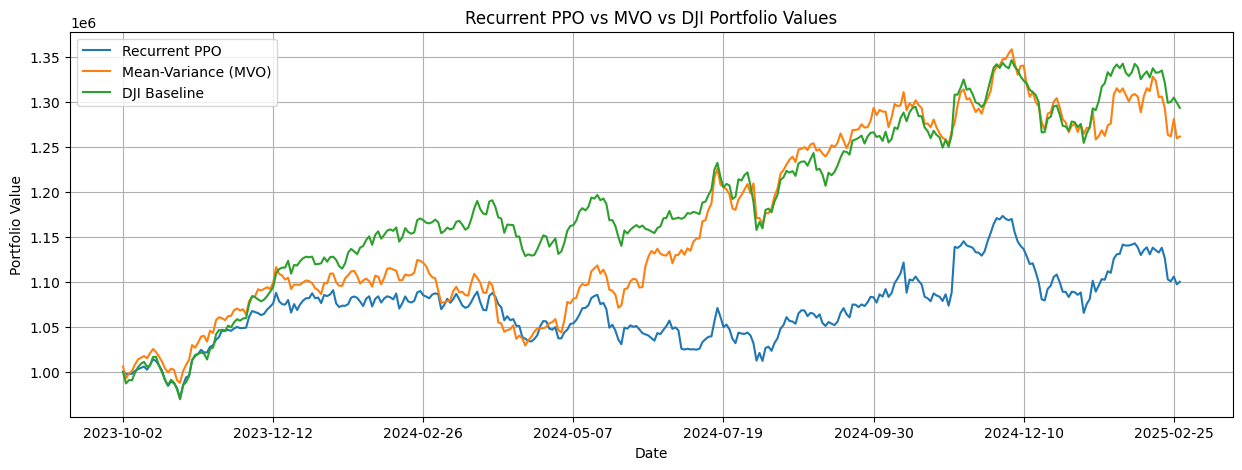

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt

# Ensure only the 3 columns we need are selected
plot_df = merged_results_df[['recurrent_ppo', 'mean_var', 'account_value']].copy()
plot_df.columns = ['Recurrent PPO', 'Mean-Variance (MVO)', 'DJI Baseline']

# Plot
plt.figure(figsize=(15, 5))
plot_df.plot(ax=plt.gca())
plt.title("Recurrent PPO vs MVO vs DJI Portfolio Values")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


In [59]:
# Get final values
final_ppo = merged_results_df['recurrent_ppo'].dropna().iloc[-1]
final_mvo = merged_results_df['mean_var'].dropna().iloc[-1]
final_dji = merged_results_df['account_value'].dropna().iloc[-1]

# Print results
print(f"Final Account Value (Recurrent PPO): {final_ppo:,.2f}")
print(f"Final Account Value (MVO): {final_mvo:,.2f}")
print(f"Final Account Value (DJI Baseline): {final_dji:,.2f}")

# Determine which is highest
final_values = {
    "Recurrent PPO": final_ppo,
    "MVO": final_mvo,
    "DJI Baseline": final_dji
}
best_strategy = max(final_values, key=final_values.get)
print(f"\nThe best performing strategy is: **{best_strategy}** with a final value of {final_values[best_strategy]:,.2f}")


Final Account Value (Recurrent PPO): 1,100,124.37
Final Account Value (MVO): 1,261,514.44
Final Account Value (DJI Baseline): 1,293,304.38

The best performing strategy is: **DJI Baseline** with a final value of 1,293,304.38
